In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("IndianFoodDatasetCSV.csv")

In [3]:
df.columns

Index(['Srno', 'RecipeName', 'TranslatedRecipeName', 'Ingredients',
       'TranslatedIngredients', 'PrepTimeInMins', 'CookTimeInMins',
       'TotalTimeInMins', 'Servings', 'Cuisine', 'Course', 'Diet',
       'Instructions', 'TranslatedInstructions', 'URL'],
      dtype='object')

In [1]:
from langchain_openai import ChatOpenAI
from datasets import Dataset
from ragas import evaluate
from ragas.run_config import RunConfig

from ragas.metrics import (
    context_precision,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_correctness,
    answer_similarity
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import streamlit as st
import requests
from dotenv import load_dotenv
from datetime import datetime, timedelta
import numpy as np
import time

load_dotenv()
working_directory = os.getcwd()









/Users/rutujakute/Downloads/evaluation/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


In [54]:
import openai
from openai import OpenAI
import os
from pinecone import Pinecone, PodSpec, ServerlessSpec
from dotenv import load_dotenv
import json

load_dotenv()

openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# The recipe name is "{row.recipename}". 
#         It has a preparation time of {row.preptimeinminutes} minutes, a cook time of "{row.cooktimeinminutes}" minutes, and a total time of "{row.totaltimeinminutes}" minutes. This recipe serves "{row.servings}" people and belongs to 
#         the "{row.cuisine}" cuisine category. This recipe falls under the "{row.course}" course category and is suitable for a "{row.diet}" diet.  The ingredients include "{row.ingredients}"
#         The instructions involve "{row.instructions}". Additionally, a YouTube link to a video demonstrating the recipe is provided:{row.youtubelink}"""
    

#     recipe_name(don’t infer): 
# ingredients:
# cooking_time(in minutes):
# cuisine: 
# servings_needed: 
# course:
# meal_type:
# cooking_instructions: 
# additional_tags(useful tags based on context): 
# diet(can be vegan, satvik, jain, no meat, pescetarian): 




def _fetchAnswerFromGPT(contextStr):
    prompt = f"""
            RecipeName (don’t infer): 
            TotalTimeInMinutes(in minutes):
            Ingredients:
            Servings:
            Cuisine: 
            Diet(can be vegan, satvik, jain, no meat, pescetarian):
            Course(can be lunch,dinner, breakfast,sidedish, main course, starter):
            Tags(useful tags based on context):
            Instructions:

           

            Fill the above from the context given below. If you are not sure(probability < 50%) then fill the field with None.
            Following is the context paragraph:
            {contextStr}
    
            """
    response = openai_client.chat.completions.create(
        model="gpt-3.5-turbo-16k",
        messages=[
            {"role": "system", "content": """You are a helpful and smart bot who tries to fill in the template given below by the context given by user. """},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content




# initialize connection to pinecone
index_name = 'fooddata'

api_key = os.getenv("PINECONE_API_KEY")
print(api_key)
pinecone_client = Pinecone(api_key=api_key)
index = pinecone_client.Index(index_name)  

def _getEmbeddingsForRecipe(text):
   
    embed_model = "text-embedding-3-small"
    text_embeddings= openai_client.embeddings.create(
        input=text if text else "Not mentioned" , model=embed_model
    ).data[0].embedding
    # print(text_embeddings)
    res = index.query(
        vector=text_embeddings,
        top_k=1,
        include_values=False,
        namespace=("Recipe")
    )
    # print("res", res)
    idList = []
    for match in res.matches:
        idList.append(match.id)
    return idList

def _getContextFromMatchingKnowledgeEmbeddings(indexes):
    res = index.fetch(ids=indexes, namespace=("Recipe"))
    contextStr = []
    for key, match in res.vectors.items():
        # match.metadata['text']
        contextStr.append({'RecipeName': match.metadata['RecipeName'],'TotalTimeInMinutes': match.metadata['TotalTimeInMinutes'],
                           'Servings': match.metadata['Servings'],'Cuisine': match.metadata['Cuisine'],'Diet': match.metadata['Diet'], 'Course': match.metadata['Course'],
                           'YoutubeLink': match.metadata['YoutubeLink'], 'CookTimeInMinutes': match.metadata['CookTimeInMinutes'],
                           'PrepTimeInMinutes':match.metadata['PrepTimeInMinutes'],'Instructions':match.metadata['Instructions'],
                           'Ingredients':match.metadata['Ingredients']})
    return contextStr

def _formatResponseWithGPT(context):
    context_text = json.dumps(context, indent=2)
    prompt = f"""
    You have been given a JSON object with recipe information. Please format this information into a clear, structured paragraph that provides a summary of the recipe, including its name, total time, ingredients, servings, cuisine, diet, course, and any other relevant tags or instructions. Here is the JSON object:

    {context_text}

    Please format it into a user-friendly paragraph.
    """
    response = openai_client.chat.completions.create(
        model="gpt-3.5-turbo-16k",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that formats recipe information into clear and structured paragraphs."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

# text = """   
#      I want pavbhaji.
#         """

def getrecommendedrecipes(text):
    response=_fetchAnswerFromGPT(text)
    # print(response)
    list=_getEmbeddingsForRecipe(text)
    # print("list:",list)
    data =_getContextFromMatchingKnowledgeEmbeddings(list)
    # print("data:",data)
    formatted_response = _formatResponseWithGPT(data)
    result = {
        "Question": text,
        "Answer": formatted_response,
        "Context": ' '.join([f"{key} is {value}." for key, value in data[0].items()])
    }
    # print("data",data[0])
    # print(result)
    return result

# getrecommendedrecipes(text)

a5183c1a-0d6e-43e8-abd9-fc76262f2ce4


In [55]:
# Function to get response from ChatOpenAI
def get_recipe_response(prompt):
    chat_client = ChatOpenAI(api_key=os.environ["OPENAI_API_KEY"])
    response = getrecommendedrecipes(prompt)
    return response

In [59]:
# Example question
recipe_question = "How do I make a perfect butter chicken?"
recipe_response = get_recipe_response(recipe_question)

# Extract answer and context from the response
recipe_answer = recipe_response.get('Answer', 'Answer not available')
recipe_context = recipe_response.get('Context', 'Context not available')

# Ensure context is a string and then place it in a list
if not isinstance(recipe_context, str):
    recipe_context = str(recipe_context)

# Even if there's only one context, it needs to be inside a list
recipe_data = {
    'question': [recipe_question],
    'answer': [recipe_answer],
    'contexts': [[recipe_context]],  # Ensuring this is a list of strings
}

# Create a dataset from the data
recipe_dataset = Dataset.from_dict(recipe_data)
print("Dataset:", recipe_dataset)

# Evaluate the dataset
recipe_score = evaluate(recipe_dataset, metrics=[faithfulness, answer_relevancy])
recipe_score_df = recipe_score.to_pandas()


Dataset: Dataset({
    features: ['question', 'answer', 'contexts'],
    num_rows: 1
})


Evaluating: 100%|██████████| 2/2 [00:15<00:00,  7.97s/it]


In [60]:
recipe_score_df

,question,answer,contexts,faithfulness,answer_relevancy
0,How do I make a perfect butter chicken?,The Butter Chicken Recipe - The Classic Indian...,[RecipeName is Butter Chicken Recipe - The Cla...,1.0,0.896263


In [63]:
# More recipe-related questions
recipe_questions = [
    "Can you suggest a simple recipe for Paneer Tikka?",
    "What's a good vegetarian dish for a party?",
    "How can I make a quick and tasty pasta?",
    "What are some traditional Indian desserts?",
    "How to prepare a healthy salad?",
    "Can you recommend a recipe for a refreshing summer drink?",
    "What's a classic recipe for Dal Makhani?",
    "How to make a delicious Biryani?",
    "Can you suggest a recipe for a comforting soup?",
    "What are some easy breakfast ideas?"
]

all_recipe_answers = []
all_recipe_contexts = []
response_times = []

# Iterating over the questions
for question in recipe_questions:
    start_time = time.time()
    recipe_response = get_recipe_response(question)
    end_time = time.time()
    
    time_elapsed = end_time - start_time
    
    answer = recipe_response['Answer']
    context = recipe_response['Context']
    all_recipe_answers.append(answer)
    all_recipe_contexts.append([context])
    response_times.append(time_elapsed)

# Storing as a Dictionary
recipe_data = {
    'question': recipe_questions,
    'answer': all_recipe_answers,
    'contexts': all_recipe_contexts,
}

# Converting to a dataset for evaluation
recipe_dataset = Dataset.from_dict(recipe_data)
recipe_scores = evaluate(recipe_dataset, metrics=[faithfulness, answer_relevancy])
recipe_metrics = recipe_scores.to_pandas()
recipe_metrics['response_time'] = response_times

# Plotting metrics
metric_data = {
    'query_index': [i for i in range(len(list(recipe_metrics['question'])))],
    'relevancy': list(recipe_metrics['answer_relevancy']),
    'response_time': list(recipe_metrics['response_time']),
    'faithfulness': list(recipe_metrics['faithfulness'])
}

metric_df = pd.DataFrame(metric_data)



Evaluating: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


In [64]:
metric_df

,query_index,relevancy,response_time,faithfulness
0,0,0.889365,9.701994,0.937500
1,1,0.804021,6.357198,1.000000
2,2,0.842199,6.359315,1.000000
3,3,0.873708,5.619396,0.954545
4,4,0.864311,5.715324,0.937500
5,5,0.883478,4.724356,1.000000
6,6,0.948500,6.251753,0.583333
7,7,0.910811,5.289978,1.000000
8,8,0.897614,4.449901,0.933333
9,9,0.818781,5.920869,0.956522


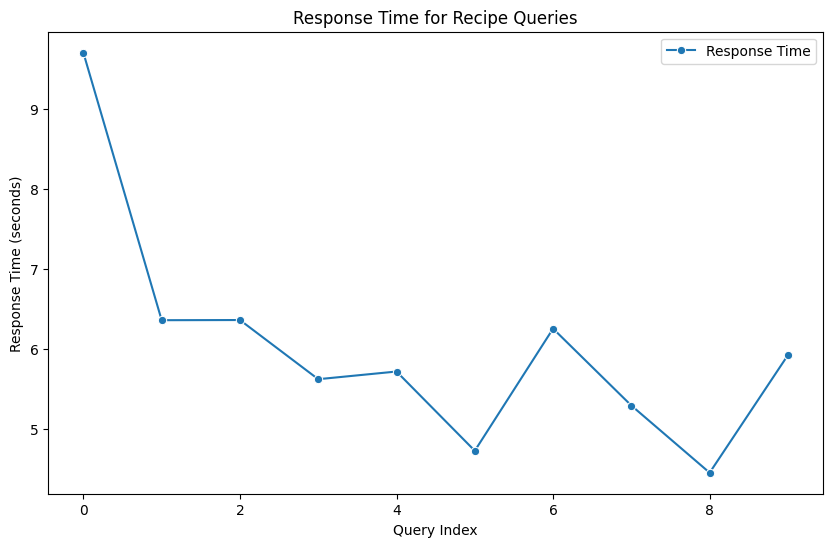

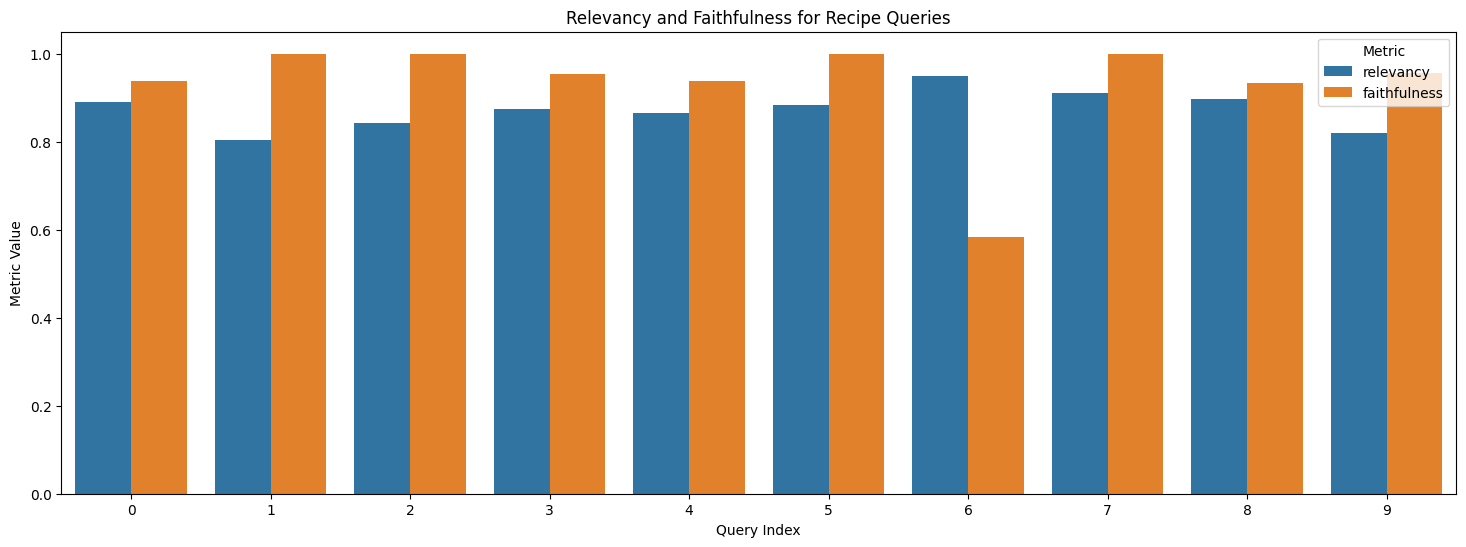

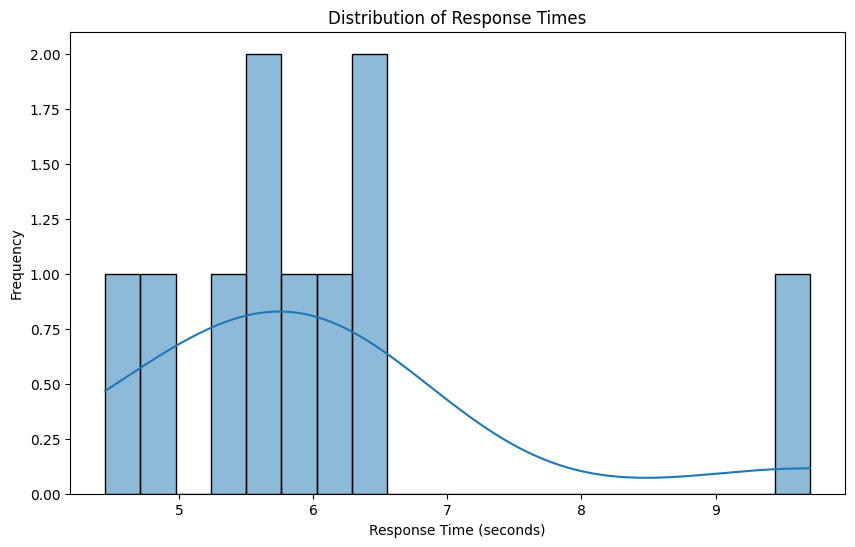

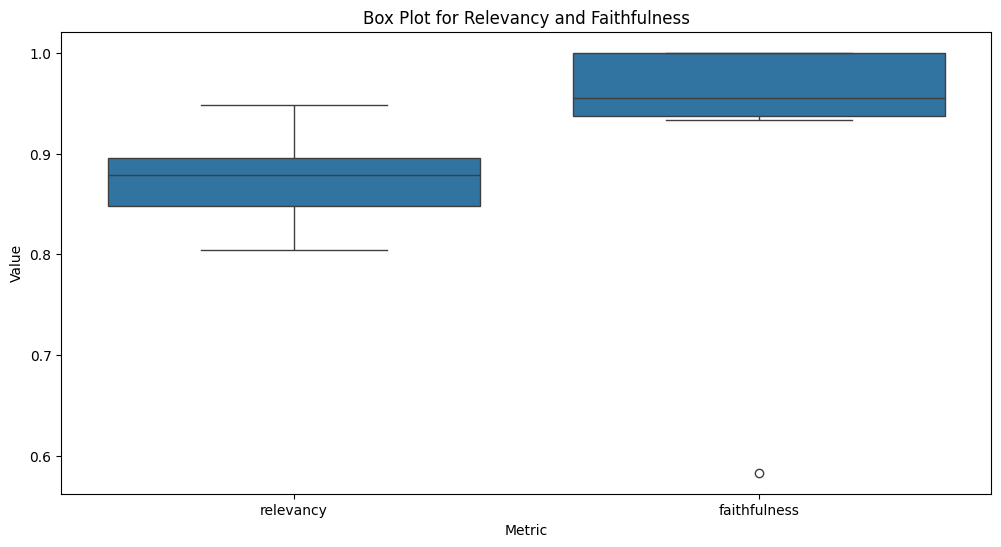

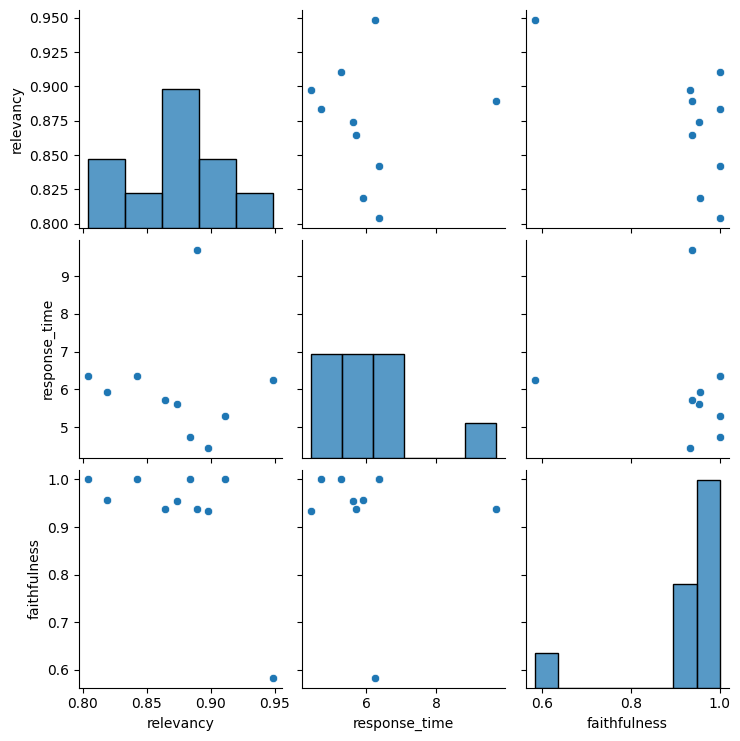

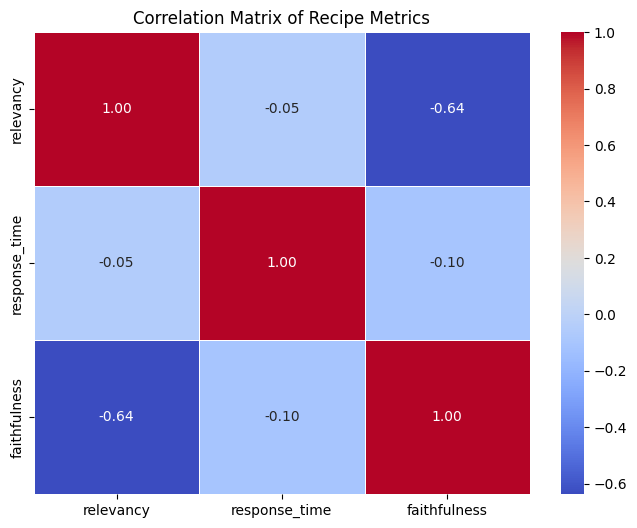

In [70]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the output directory exists
output_dir = os.path.join(working_directory, "Images")
os.makedirs(output_dir, exist_ok=True)

# Line plot for response time
plt.figure(figsize=(10, 6)) 
sns.lineplot(x='query_index', y='response_time', data=metric_df, marker='o', label='Response Time')
plt.xlabel('Query Index')
plt.ylabel('Response Time (seconds)')
plt.title('Response Time for Recipe Queries')
plt.legend()
plt.savefig(os.path.join(output_dir, "response_time_line_plot.png"))
plt.show()

# Bar plot for relevancy and faithfulness
melted_metric_df = metric_df.melt(id_vars='query_index', value_vars=['relevancy', 'faithfulness'], var_name='Metric', value_name='Value')

plt.figure(figsize=(18, 6))
sns.barplot(x='query_index', y='Value', hue='Metric', data=melted_metric_df)
plt.xlabel('Query Index')
plt.ylabel('Metric Value')
plt.title('Relevancy and Faithfulness for Recipe Queries')
plt.legend(title='Metric')
plt.savefig(os.path.join(output_dir, "relevancy_faithfulness_bar_plot.png"))
plt.show()

# Histogram for response time
plt.figure(figsize=(10, 6))
sns.histplot(metric_df['response_time'], bins=20, kde=True)
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times')
plt.savefig(os.path.join(output_dir, "response_time_histogram.png"))
plt.show()

# Box plot for relevancy and faithfulness
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_metric_df, x='Metric', y='Value')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Box Plot for Relevancy and Faithfulness')
plt.savefig(os.path.join(output_dir, "relevancy_faithfulness_box_plot.png"))
plt.show()

# Pair plot for all metrics
sns.pairplot(metric_df[['relevancy', 'response_time', 'faithfulness']])
plt.savefig(os.path.join(output_dir, "metrics_pair_plot.png"))
plt.show()

# Heatmap for correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = metric_df[['relevancy', 'response_time', 'faithfulness']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Recipe Metrics')
plt.savefig(os.path.join(output_dir, "correlation_matrix_heatmap.png"))
plt.show()
